In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for better visualization
sns.set_style("whitegrid")

# 1. Data Loading and Cleaning
# Load the dataset
df = pd.read_csv("C:/Users/syedn/Downloads/ifood_df.csv")
# Handle missing values in 'Income' by dropping them as it's a critical feature for spending analysis
# Dropping rows with missing Income is a common approach in this context.
df.dropna(subset=['Income'], inplace=True)

# Select features for segmentation
# R (Recency) is 'Recency'
# M (Monetary) is MntTotal
# F (Frequency) is (NumWebPurchases + NumCatalogPurchases + NumStorePurchases)
# Other useful features: Kidhome, Teenhome, AcceptedCmpOverall, Age
segmentation_features = [
'Recency', # Days since last purchase (R)
'MntTotal', # Total amount spent (M)
'NumDealsPurchases', # Frequency proxy, but also deal sensitivity
'NumWebPurchases',
'NumCatalogPurchases',
'NumStorePurchases',
'Income', # Key demographic
'Age', # Key demographic (assuming Age has been calculated correctly in preprocessing)
'Kidhome',
'Teenhome',
'AcceptedCmpOverall' # Campaign acceptance history
]
# Create a feature 'MntTotal' (Monetary) which is the sum of all product spending
df['MntTotal'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

# Create 'Age' from 'Customer_Days' which is a more interpretable feature
# Assuming 'Customer_Days' represents the total number of days the customer has been with the company
# The dataset has an 'Age' column already, let's use it directly.
# df['Age'] = 2024 - df['Year_Birth'] # Recalculate if Year_Birth was present, but let's trust the existing 'Age'

# The final feature set for clustering
X = df[segmentation_features].copy()
X



,Recency,MntTotal,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Income,Age,Kidhome,Teenhome,AcceptedCmpOverall
0,58,1617,3,8,10,4,58138.0,63,0,0,0
1,38,27,2,1,1,2,46344.0,66,1,1,0
2,26,776,1,8,2,10,71613.0,55,0,0,0
3,26,53,2,2,0,4,26646.0,36,1,0,0
4,94,422,5,5,3,6,58293.0,39,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2200,46,1341,2,9,3,4,61223.0,53,0,1,0
2201,56,444,7,8,2,5,64014.0,74,2,1,1
2202,91,1241,1,2,3,13,56981.0,39,0,0,1
2203,8,843,2,6,5,10,69245.0,64,0,1,0


In [8]:
# 2. Data Scaling
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit and transform the data
X_scaled = scaler.fit_transform(X)

# Convert back to a DataFrame for clarity
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df


,Recency,MntTotal,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Income,Age,Kidhome,Teenhome,AcceptedCmpOverall
0,0.310830,1.679323,0.361479,1.424772,2.628526,-0.562650,0.314651,1.017189,-0.823405,-0.930767,-0.439991
1,-0.380600,-0.963897,-0.168834,-1.132957,-0.588043,-1.179732,-0.254877,1.273530,1.038757,0.906602,-0.439991
2,-0.795458,0.281242,-0.699147,1.424772,-0.230646,1.288596,0.965354,0.333612,-0.823405,-0.930767,-0.439991
3,-0.795458,-0.920675,-0.168834,-0.767567,-0.945440,-0.562650,-1.206087,-1.289883,1.038757,-0.930767,-0.439991
4,1.555404,-0.307248,1.422105,0.328602,0.126750,0.054432,0.322136,-1.033542,1.038757,-0.930767,-0.439991
...,...,...,...,...,...,...,...,...,...,...,...
2200,-0.104028,1.220500,-0.168834,1.790162,0.126750,-0.562650,0.463624,0.162718,-0.823405,0.906602,-0.439991
2201,0.241687,-0.270675,2.482731,1.424772,-0.230646,-0.254109,0.598401,1.957107,2.900920,0.906602,1.029979
2202,1.451690,1.054260,-0.699147,-0.767567,0.126750,2.214218,0.258780,-1.033542,-0.823405,-0.930767,1.029979
2203,-1.417746,0.392623,-0.168834,0.693992,0.841543,1.288596,0.851004,1.102636,-0.823405,0.906602,-0.439991


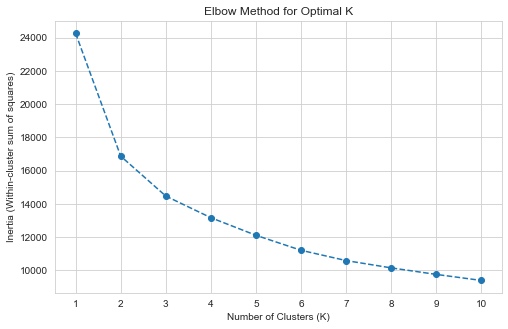

In [9]:
# 3. Optimal K Determination (Elbow Method)
inertia = []
# Test K from 1 to 10
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [10]:
# 4. K-Means Clustering
# Initialize and fit the K-Means model with the optimal K
K_OPTIMAL = 4
kmeans_model = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10)
df['Cluster'] = kmeans_model.fit_predict(X_scaled)
df['Cluster'] 

0       0
1       1
2       0
3       3
4       3
       ..
2200    2
2201    2
2202    0
2203    2
2204    1
Name: Cluster, Length: 2205, dtype: int32


--- Cluster Profile (Mean Values) ---
         Recency  MntTotal  NumDealsPurchases  NumWebPurchases  \
Cluster                                                          
0          24.05     98.98               1.78             2.22   
1          51.67   1329.71               1.09             4.65   
2          73.97    913.28               2.94             6.85   
3          47.95   1308.75               1.13             4.94   
4          74.11     97.17               1.90             2.26   
5          47.93    522.16               7.22             5.85   
6          48.80   1607.20               1.17             5.49   
7          51.21    171.64               1.59             2.60   
8          22.24    797.30               3.10             6.65   
9          50.19     77.15               2.43             1.87   

         NumCatalogPurchases  NumStorePurchases    Income    Age  Kidhome  \
Cluster                                                                     
0             

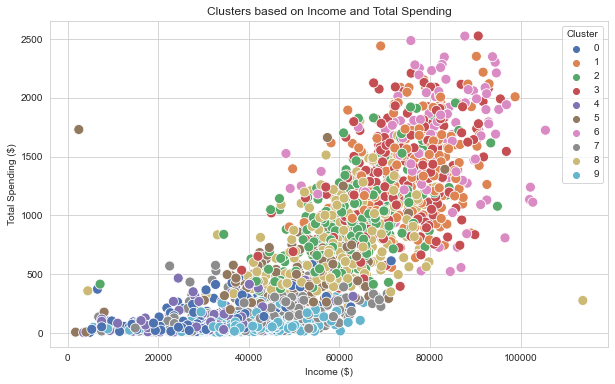

In [11]:
# 5. Profiling Clusters
# Aggregate the original (unscaled) data by cluster to understand the segments
df['Cluster'] = kmeans.labels_
cluster_profile = df.groupby('Cluster')[segmentation_features].mean()

# Add a column for the size of each cluster
cluster_profile['Count'] = df['Cluster'].value_counts().sort_index()

# Add the mean 'Response' rate for each cluster
cluster_profile['Response_Rate'] = df.groupby('Cluster')['Response'].mean() * 100

print("\n--- Cluster Profile (Mean Values) ---")
print(cluster_profile.round(2))

# Visualize the clusters based on key features (e.g., MntTotal vs Income)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income', y='MntTotal', hue='Cluster', data=df, palette='deep', s=100)
plt.title('Clusters based on Income and Total Spending')
plt.xlabel('Income ($)')
plt.ylabel('Total Spending ($)')
plt.legend(title='Cluster')
plt.show()


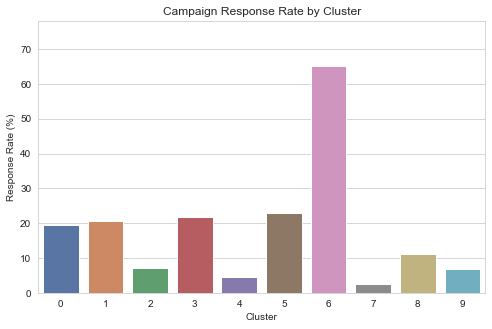

In [12]:
# Visualize the cluster response rates
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_profile.index, y='Response_Rate', data=cluster_profile, palette='deep')
plt.title('Campaign Response Rate by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Response Rate (%)')
plt.ylim(0, cluster_profile['Response_Rate'].max()*1.2)
plt.show()